<a href="https://colab.research.google.com/github/Jawahars/ai-gan/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Hyperparameters
lr = 0.0002
batch_size = 128
image_size = 64
channels_img = 1
z_dim = 100
num_epochs = 5
features_d = 64
features_g = 64

### Transformations


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
        ),
    ]
)

In [4]:
# Load MNIST dataset
dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 514kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]


In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

In [7]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator(z_dim, channels_img, features_g).to(device)
disc = Discriminator(channels_img, features_d).to(device)

In [8]:
# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [9]:
# for tensorboard
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

## Training

Epoch [0/5] Batch 0/469                   Loss D: 0.6957, loss G: 2.4268
Epoch [0/5] Batch 100/469                   Loss D: 0.0017, loss G: 7.1910
Epoch [0/5] Batch 200/469                   Loss D: 0.0009, loss G: 7.6360
Epoch [0/5] Batch 300/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [0/5] Batch 400/469                   Loss D: 50.0000, loss G: 0.0000


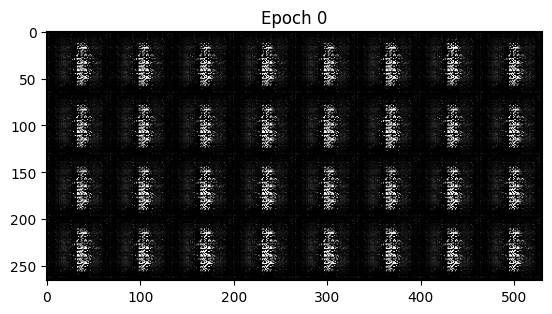

Epoch [1/5] Batch 0/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [1/5] Batch 100/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [1/5] Batch 200/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [1/5] Batch 300/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [1/5] Batch 400/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [2/5] Batch 0/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [2/5] Batch 100/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [2/5] Batch 200/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [2/5] Batch 300/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [2/5] Batch 400/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [3/5] Batch 0/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [3/5] Batch 100/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [3/5] Batch 200/469                   Loss D: 50.0000, loss G: 0.0000
Epoch [3/5] Batch 

In [10]:
gen.train()
disc.train()

# Lists to store losses for plotting
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Save Losses for plotting later
        G_losses.append(loss_gen.item())
        D_losses.append(loss_disc.item())

        # Print losses & write to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take up to 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

    # Generated samples every 5 epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            fake = gen(fixed_noise).to("cpu")
            # make grid takes tensor and returns Image
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            plt.imshow(img_grid_fake.permute(1, 2, 0))
            plt.title(f"Epoch {epoch}")
            plt.show()



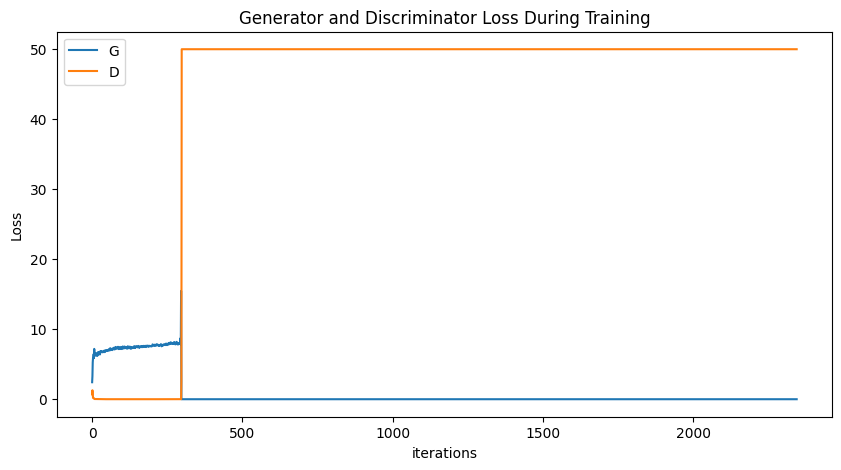

In [11]:
# Plotting the loss curves
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()